
# Tarea N°02
## Instrucciones
1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.

**Nombre**: Hugo Rocha

**Rol**: 201610531-K

2.- Debes pushear este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:

- Soluciones
- Código
- Que Binder esté bien configurado.
- Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [1]:
import numpy as np
import pandas as pd
import warnings
from sklearn import datasets
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from matplotlib.pyplot import imshow
from metrics_classification import *
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [3]:
digits_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [4]:
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 6 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [5]:
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada! Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
* ¿Cuánta memoria estoy utilizando?
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

In [6]:
digits.describe().T

,count,mean,std,min,25%,50%,75%,max
c00,1797.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
c01,1797.0,0.303840,0.907192,0.0,0.0,0.0,0.0,8.0
c02,1797.0,5.204786,4.754826,0.0,1.0,4.0,9.0,16.0
c03,1797.0,11.835838,4.248842,0.0,10.0,13.0,15.0,16.0
c04,1797.0,11.848080,4.287388,0.0,10.0,13.0,15.0,16.0
...,...,...,...,...,...,...,...,...
c60,1797.0,11.809126,4.933947,0.0,10.0,14.0,16.0,16.0
c61,1797.0,6.764051,5.900623,0.0,0.0,6.0,12.0,16.0
c62,1797.0,2.067891,4.090548,0.0,0.0,0.0,2.0,16.0
c63,1797.0,0.364496,1.860122,0.0,0.0,0.0,0.0,16.0


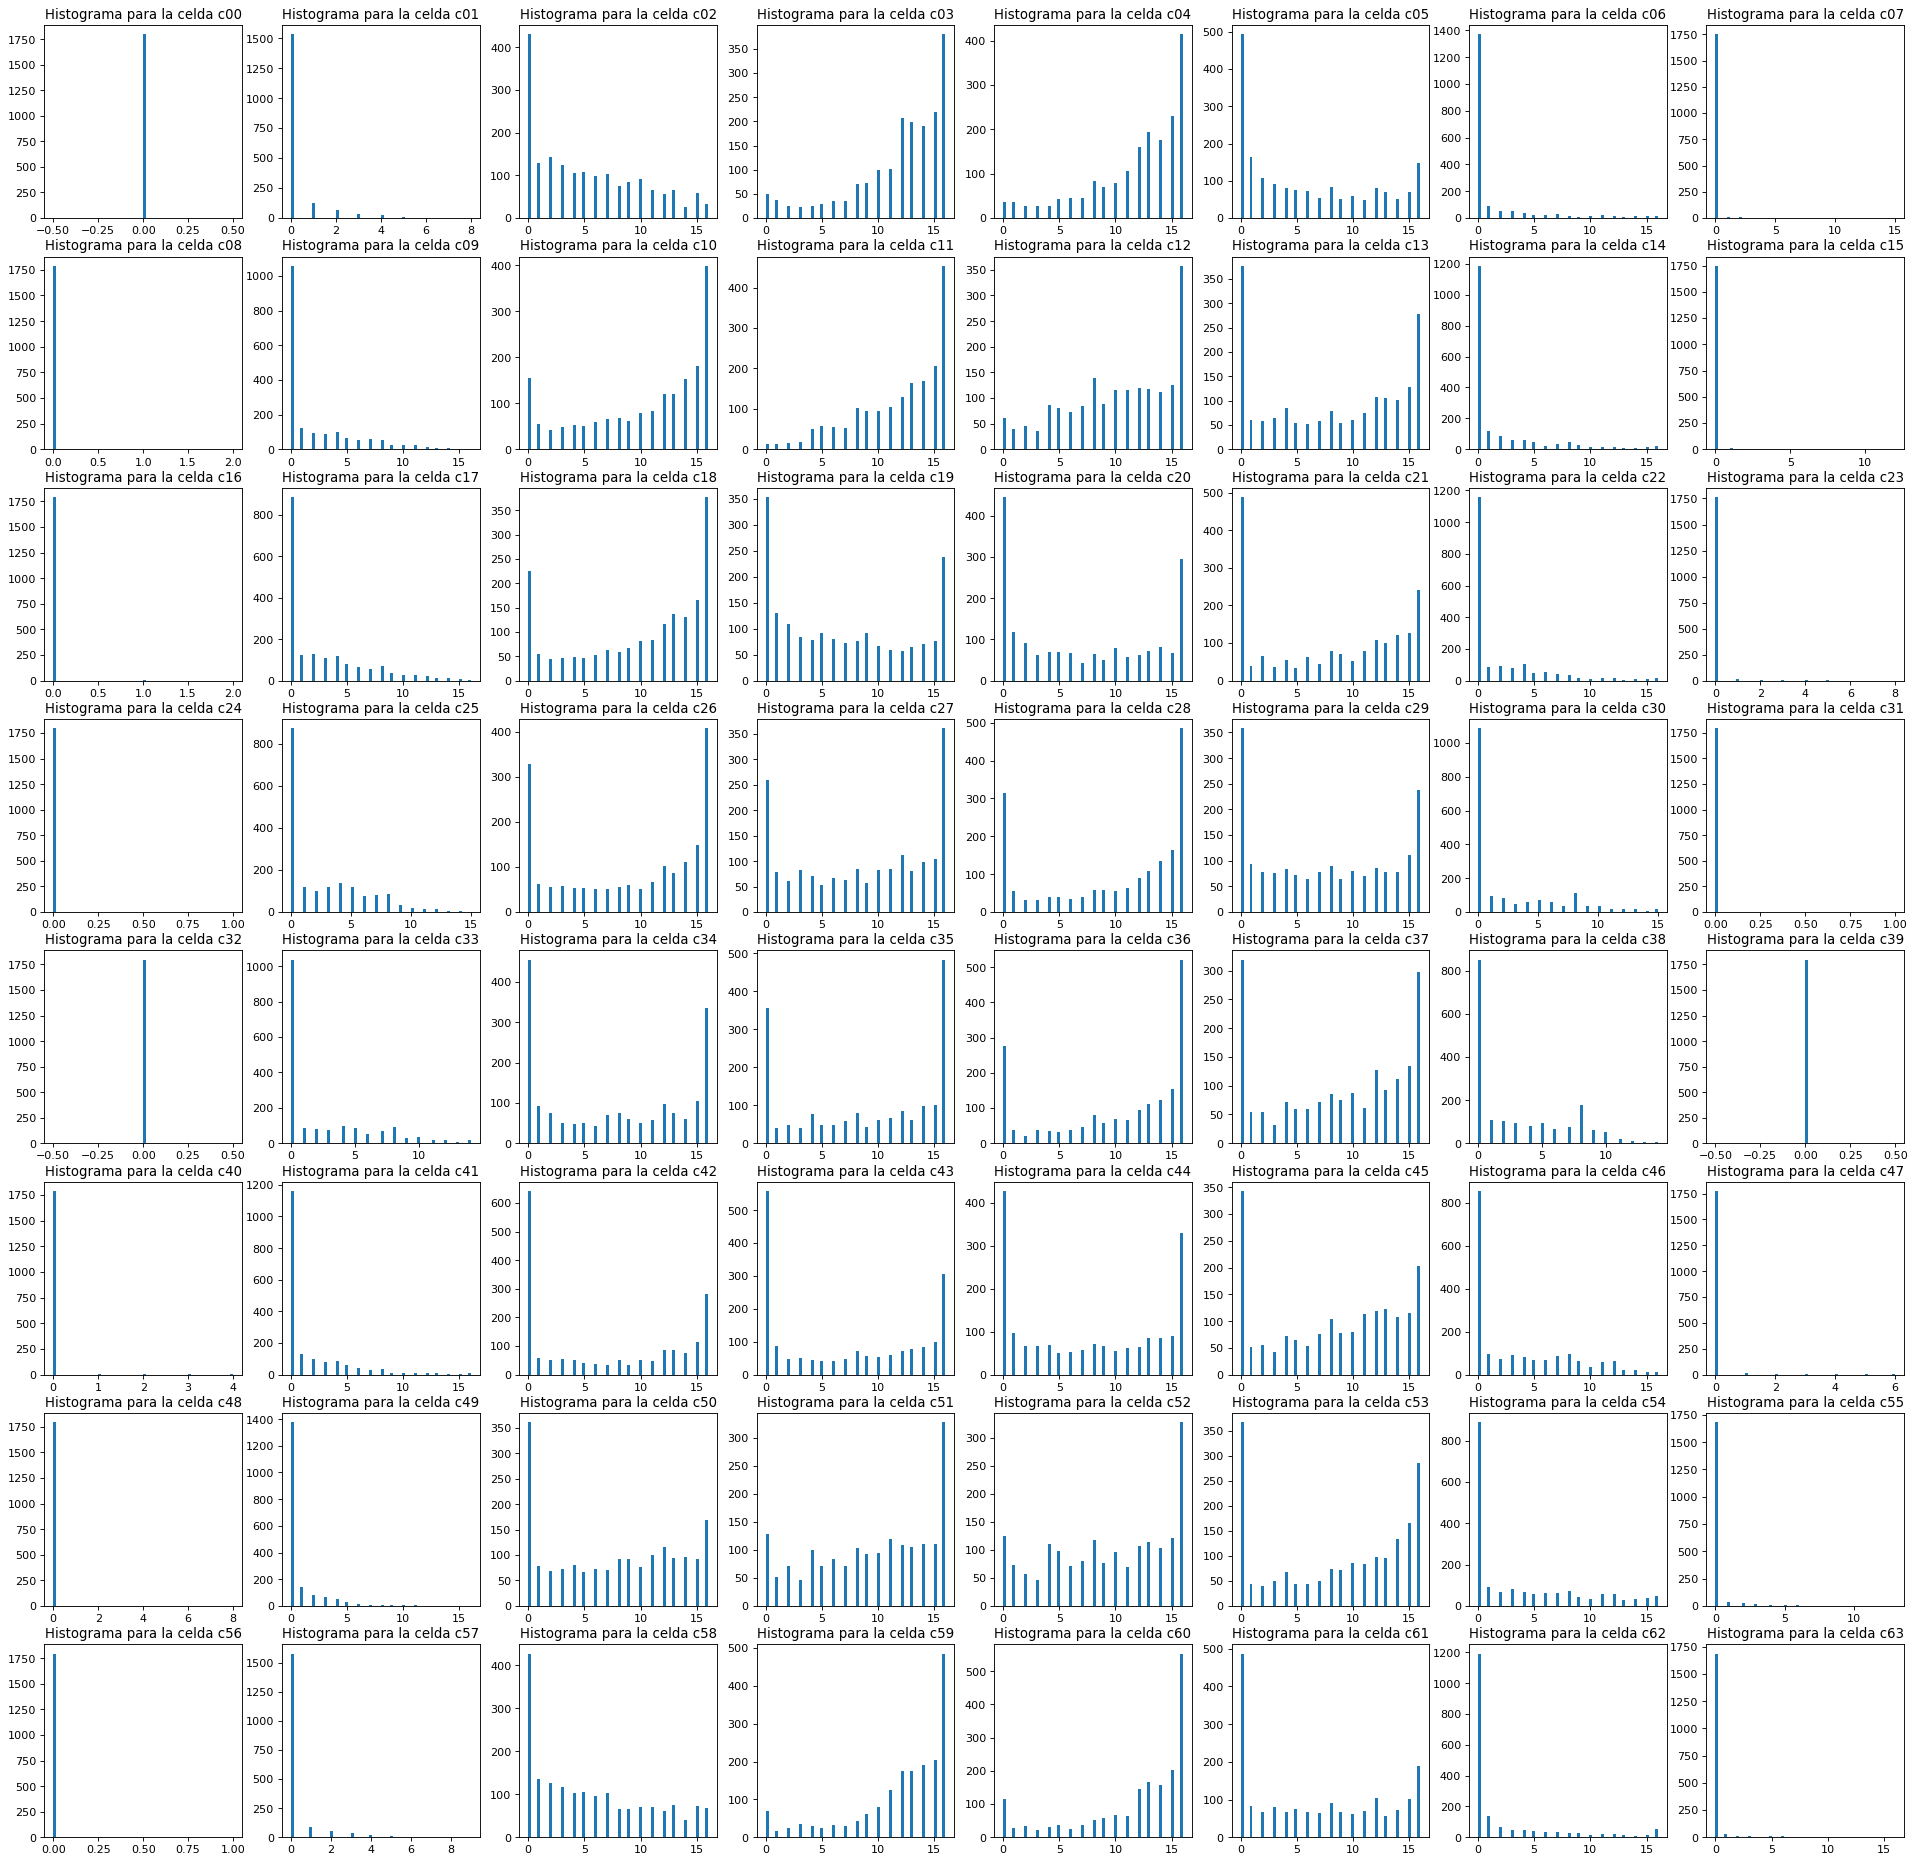

In [7]:
aux=digits.drop(['target'],axis=1) #Creamos un arreglo auxiliar en el cual nos deshacemos de la columna target
figure(num=None, figsize=(30, 30), dpi=80) #Ajustamos nuestra ventana de ploteo
j=1 #Establesemos un contador para el ploteo.
for i in aux.columns: #Recorremos las columnas y generamos un histograma por vcada una de ellas.
    plt.subplot(8,8,j)
    plt.hist(aux[i], bins = 60)
    plt.title('Histograma para la celda '+i)
    #plt.xlabel('Celda',i)
    #plt.ylabel('Frecuencia')
    j+=1

plt.show()

In [8]:
digits.dtypes.unique() #Veamos el tipo de objetos

array([dtype('int32')], dtype=object)

Con esto ultimo nos aseguramos de no tener datos perdidos y que solo estamos trabajando con valores enteros.

In [9]:
digits.describe().T['count'].unique() #Veamos que todas las columnas tengan la misma cantidad de observaciones.

array([1797.])

In [10]:
digits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   c00     1797 non-null   int32
 1   c01     1797 non-null   int32
 2   c02     1797 non-null   int32
 3   c03     1797 non-null   int32
 4   c04     1797 non-null   int32
 5   c05     1797 non-null   int32
 6   c06     1797 non-null   int32
 7   c07     1797 non-null   int32
 8   c08     1797 non-null   int32
 9   c09     1797 non-null   int32
 10  c10     1797 non-null   int32
 11  c11     1797 non-null   int32
 12  c12     1797 non-null   int32
 13  c13     1797 non-null   int32
 14  c14     1797 non-null   int32
 15  c15     1797 non-null   int32
 16  c16     1797 non-null   int32
 17  c17     1797 non-null   int32
 18  c18     1797 non-null   int32
 19  c19     1797 non-null   int32
 20  c20     1797 non-null   int32
 21  c21     1797 non-null   int32
 22  c22     1797 non-null   int32
 23  c23     1797 

### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [11]:
digits_dict["images"][1]

array([[ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.],
       [ 0.,  0.,  0., 11., 16.,  9.,  0.,  0.],
       [ 0.,  0.,  3., 15., 16.,  6.,  0.,  0.],
       [ 0.,  7., 15., 16., 16.,  2.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  3.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
       [ 0.,  0.,  0., 11., 16., 10.,  0.,  0.]])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

Sugerencia: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

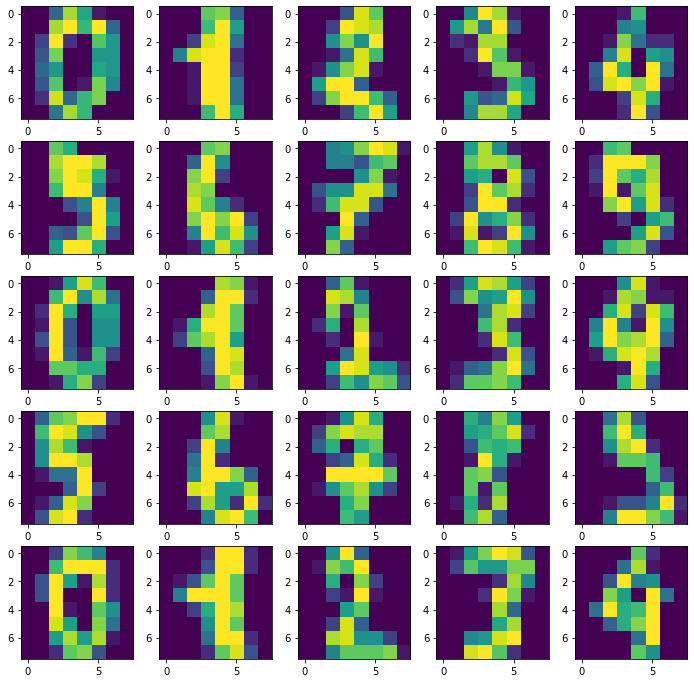

In [12]:
nx, ny = 5, 5
fig, axs = plt.subplots(nx, ny, figsize=(12, 12))
j=1
for i in range(0,25):
    plt.subplot(5,5,j)
    imshow(digits_dict["images"][i])
    j+=1
    

### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


In [13]:
X = digits.drop(columns="target").values
y = digits["target"].values

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [15]:
print('El largo del conjunto de entrenamiento es ',len(X_train) ,' y el largo del conjunto de testeo es', len(X_test))

El largo del conjunto de entrenamiento es  1437  y el largo del conjunto de testeo es 360


In [16]:
parametros={'penalty':['l1','l2','elasticnet'] , 'C':range(10)}
from sklearn.linear_model import LogisticRegression
rlog = LogisticRegression()
grid=GridSearchCV(rlog,parametros)
grid.fit(X_train,Y_train)
print("Los mejores parametros son: %f con %s" % (grid.best_score_, grid.best_params_))


Los mejores parametros son: 0.954063 con {'C': 1, 'penalty': 'l2'}


In [17]:
rlogfinal=LogisticRegression(C=grid.best_params_['C'],penalty=grid.best_params_['penalty'])
rlogfinal.fit(X_train,Y_train)
Y_pred=rlogfinal.predict(X_test)
print('\nMatriz de confusion:\n ')
print(confusion_matrix(Y_test,Y_pred))
df_temp = pd.DataFrame(
    {
        'y':Y_test,
        'yhat':Y_pred
        }
)

df_metrics = summary_metrics(df_temp)
print("")
print(df_metrics)


Matriz de confusion:
 
[[33  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 33  0  1  0  0  0  0]
 [ 0  1  0  0 44  0  1  0  0  0]
 [ 0  0  1  0  0 44  1  0  0  1]
 [ 0  0  0  0  0  1 34  0  0  0]
 [ 0  0  0  0  0  1  0 33  0  0]
 [ 0  0  0  0  0  1  0  0 29  0]
 [ 0  0  0  1  0  0  0  0  1 38]]

   accuracy  recall  precision  fscore
0    0.9694  0.9722     0.9709  0.9714


In [18]:
from sklearn.neighbors import KNeighborsClassifier
parametros={'n_neighbors':range(0,10)}
KN=KNeighborsClassifier()
grid=GridSearchCV(KN,parametros)
grid.fit(X_train,Y_train)
print("Los mejores parametros son: %f con %s" % (grid.best_score_, grid.best_params_))

Los mejores parametros son: 0.986082 con {'n_neighbors': 1}


In [19]:
KNfinal=KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])
KNfinal.fit(X_train,Y_train)
Y_pred=KNfinal.predict(X_test)
print('\nMatriz de confusion:\n ')
print(confusion_matrix(Y_test,Y_pred))
df_temp = pd.DataFrame(
    {
        'y':Y_test,
        'yhat':Y_pred
        }
)

df_metrics = summary_metrics(df_temp)
print("")
print(df_metrics)


Matriz de confusion:
 
[[33  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 34  0  0  0  0  0  0]
 [ 0  1  0  0 45  0  0  0  0  0]
 [ 0  0  0  0  0 46  1  0  0  0]
 [ 0  0  0  0  0  0 35  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  1]
 [ 0  1  0  0  0  0  0  0 28  1]
 [ 0  0  0  1  1  1  0  0  0 37]]

   accuracy  recall  precision  fscore
0    0.9778  0.9786     0.9783  0.9781


In [20]:
from sklearn.ensemble import RandomForestClassifier
parametros={'max_depth':range(0,10),'criterion':['gini', 'entropy'],'min_samples_leaf':range(1,10)}
RF=RandomForestClassifier()
grid=GridSearchCV(RF,parametros)
grid.fit(X_train,Y_train)
print("Los mejores parametros son: %f con %s" % (grid.best_score_, grid.best_params_))

Los mejores parametros son: 0.971465 con {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 2}


In [21]:
RFfinal=RandomForestClassifier(max_depth=grid.best_params_['max_depth'],criterion=grid.best_params_['criterion'],min_samples_leaf=grid.best_params_['min_samples_leaf'])
RFfinal.fit(X_train,Y_train)
Y_pred=RFfinal.predict(X_test)
print('\nMatriz de confusion:\n ')
print(confusion_matrix(Y_test,Y_pred))
df_temp = pd.DataFrame(
    {
        'y':Y_test,
        'yhat':Y_pred
        }
)

df_metrics = summary_metrics(df_temp)
print("")
print(df_metrics)


Matriz de confusion:
 
[[32  0  0  0  1  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 33  0  1  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  0  0 46  1  0  0  0]
 [ 0  0  0  0  0  1 34  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  1]
 [ 0  1  0  0  0  0  0  0 29  0]
 [ 0  0  0  0  0  1  0  0  1 38]]

   accuracy  recall  precision  fscore
0    0.9778  0.9778     0.9795  0.9785


In [22]:
from sklearn.svm import SVC
from sklearn import svm
parametros= { 'kernel' :('linear','poly','rbf', 'sigmoid') , 'C':range(10),'decision_function_shape':['ovo', 'ovr']}
clf =svm.SVC()
grid=GridSearchCV(clf,parametros)
grid.fit(X_train,Y_train)
print("Los mejores parametros son: %f con %s" % (grid.best_score_, grid.best_params_))

Los mejores parametros son: 0.991655 con {'C': 7, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}


In [24]:
clf_final=svm.SVC(kernel=grid.best_params_['kernel'],C=grid.best_params_['C'],decision_function_shape=grid.best_params_['decision_function_shape'])
clf_final.fit(X_train,Y_train)
Y_pred=clf_final.predict(X_test)
print('\nMatriz de confusion:\n ')
print(confusion_matrix(Y_test,Y_pred))
df_temp = pd.DataFrame(
    {
        'y':Y_test,
        'yhat':Y_pred
        }
)

df_metrics = summary_metrics(df_temp)
print("")
print(df_metrics)



Matriz de confusion:
 
[[33  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 33  0  1  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  0  0 46  1  0  0  0]
 [ 0  0  0  0  0  0 35  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  1]
 [ 0  0  0  0  0  1  0  0 29  0]
 [ 0  0  0  0  0  0  0  1  0 39]]

   accuracy  recall  precision  fscore
0    0.9861  0.9862     0.9876  0.9868


### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asocados al modelo en estudio, para ello debe resolver los siguientes puntos:



 * **Cross validation**: usando **cv** (con n_fold = 10), sacar una especie de "intervalo de confianza" sobre alguna de las métricas estudiadas en clases: 
  * $\mu \pm \sigma$ = promedio $\pm$ desviación estandar
 * **Curva de Validación**: Replica el ejemplo del siguiente [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.

In [25]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(clf_final,X,y,cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: 0.98 (+/- 0.03)


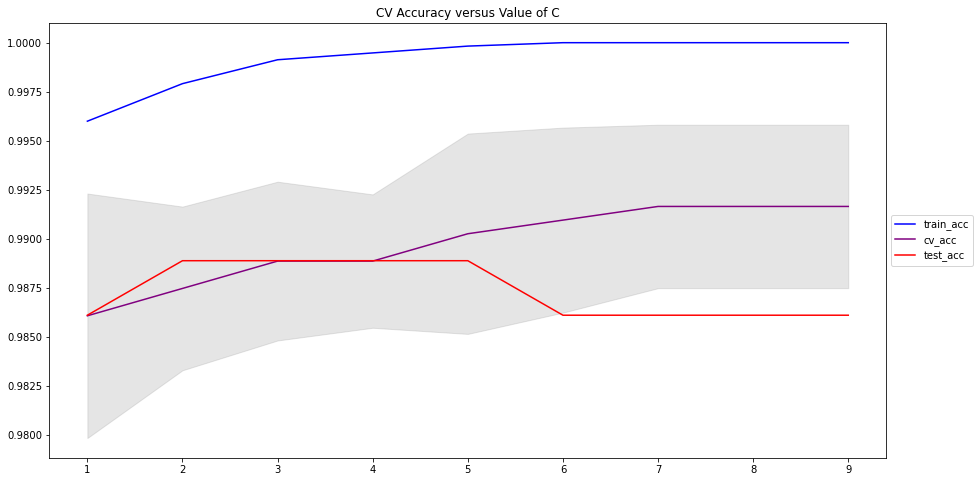

In [26]:
parameters = {'kernel':['rbf'], 'C': range(1,10)}
svm = SVC()
grid1 = GridSearchCV(svm, parameters,return_train_score=True)
grid1.fit(X_train,Y_train)
Vals_C= range(1,10)
test_accuracy = []
for val in Vals_C:
    svm = SVC(kernel='rbf', C=val)
    svm.fit(X_train,Y_train)
    test_accuracy.append(svm.score(X_test,Y_test))


fig, ax = plt.subplots(figsize=(15,8))
ax.plot(Vals_C,grid1.cv_results_['mean_train_score'],color='b',lw=1.5,label='train_acc')
ax.plot(Vals_C,grid1.cv_results_['mean_test_score'],color='purple',lw=1.5,label='cv_acc')
ax.plot(Vals_C,test_accuracy,color='r',lw=1.5,label='test_acc')
plt.fill_between(Vals_C, grid1.cv_results_['mean_test_score']-grid1.cv_results_['std_test_score'], grid1.cv_results_['mean_test_score']+grid1.cv_results_['std_test_score'],color='gray', alpha=0.2)
plt.title("CV Accuracy versus Value of C")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [27]:
y_test=label_binarize(Y_test, classes=[i for i in range(10)])
classifier = OneVsRestClassifier(SVC(kernel='rbf',C=3, probability=True,
                                 random_state=42))
y_score = classifier.fit(X_train, Y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

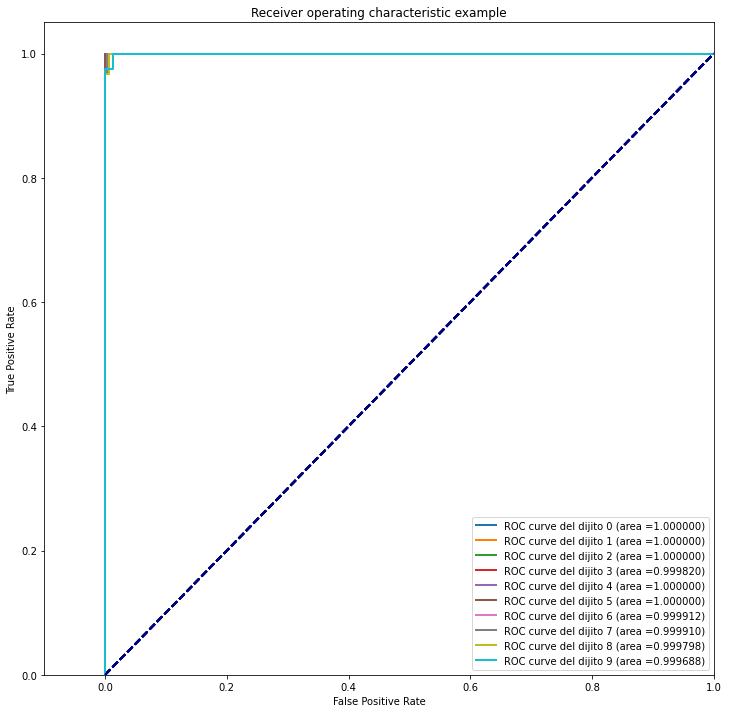

In [28]:
plt.figure(figsize=(12, 12))
lw = 2
for i in range(10):
    plt.plot(fpr[i], tpr[i],
             lw=lw, label='ROC curve del dijito {0} (area ={1:f})'
             ''.format(i,roc_auc[i])   )
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.1, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
plt.show()  

### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una redcción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [30]:
# Separamos las columnas objetivo
x_training = digits.drop(['target',], axis=1)
y_training = digits['target']

# Aplicando el algoritmo univariante de prueba F.
k = 48  # número de atributos a seleccionar
columnas = list(x_training.columns.values)
seleccionadas = SelectKBest(f_classif, k=k).fit(x_training, y_training)
catrib = seleccionadas.get_support()
atributos = [columnas[i] for i in list(catrib.nonzero()[0])]
digits[atributos]

,c01,c02,c03,c04,c05,c06,c09,c10,c11,c12,...,c52,c53,c54,c57,c58,c59,c60,c61,c62,c63
0,0,5,13,9,1,0,0,13,15,10,...,10,12,0,0,6,13,10,0,0,0
1,0,0,12,13,5,0,0,0,11,16,...,16,6,0,0,0,11,16,10,0,0
2,0,0,4,15,12,0,0,3,16,15,...,16,11,5,0,0,3,11,16,9,0
3,0,7,15,13,1,0,8,13,6,15,...,5,14,9,0,7,13,13,9,0,0
4,0,0,1,11,0,0,0,0,7,8,...,15,10,0,0,0,2,16,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0,4,10,13,6,0,1,16,14,12,...,7,16,4,0,2,14,15,9,0,0
1793,0,6,16,13,11,1,0,16,15,12,...,16,16,1,0,6,16,14,6,0,0
1794,0,1,11,15,1,0,0,13,16,8,...,15,16,0,0,2,9,13,6,0,0
1795,0,2,10,7,0,0,0,14,16,16,...,7,16,2,0,5,12,16,12,0,0


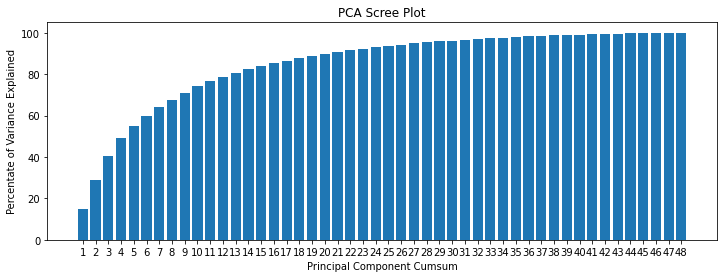

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=48)
principalComponents = pca.fit_transform(digits[atributos])

# graficar varianza por componente
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
percent_variance_cum = np.cumsum(percent_variance)
columns=[str(x) for x in range(1,49)]

plt.figure(figsize=(12,4))
plt.bar(x= range(1,49), height=percent_variance_cum, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component Cumsum')
plt.title('PCA Scree Plot')
plt.show()


In [32]:
l=list()
for i in range(0,len(percent_variance)):
    if int(percent_variance_cum[i]) >= 80: #Criterio para la varianza acummulada.
        l.append(i+1)
Cant_de_comp=l[0]        


In [33]:
numero=Cant_de_comp
pca = PCA(n_components=numero)
columnas=[str(x) for x in range(1,numero+1)]
principalComponents = pca.fit_transform(digits[atributos])

principalDataframe = pd.DataFrame(data = principalComponents, columns =columnas)
targetDataframe = digits['target']

newDataframe = pd.concat([principalDataframe, targetDataframe],axis = 1)
newDataframe

,1,2,3,4,5,6,7,8,9,10,11,12,13,target
0,-1.226133,21.283019,-9.426652,13.001327,-7.047362,-7.511788,3.123216,2.551327,-0.585278,-3.656176,2.606278,1.653301,-1.419763,0
1,7.929799,-20.785025,4.374838,-14.895682,5.945321,-6.510907,2.028437,-4.516593,3.595879,1.044535,-5.181324,-2.239186,1.845234,1
2,7.006352,-10.004669,2.855354,-12.336732,-18.021418,-4.611528,1.706684,-16.497491,1.063899,-4.025715,-1.329234,-0.462502,0.789979,2
3,-15.899774,3.336991,9.868876,-12.283315,6.956499,1.213784,-0.911839,10.915108,-3.323323,-6.681003,-4.944694,2.271416,-3.355836,3
4,23.304727,4.254429,-5.699318,-13.859508,-0.282976,-2.714881,-0.629439,12.948642,-3.817171,-13.645339,2.864805,-1.489707,5.314417,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,-14.610506,13.406753,-13.379297,-6.476624,3.795078,-2.743959,-4.558632,-3.731068,7.158822,8.568805,-1.009622,6.517545,0.579627,9
1793,6.491549,20.571825,-9.119998,12.546603,-8.904018,-13.895184,3.551272,-3.714211,-7.352257,5.040446,-3.480950,4.472462,3.824696,0
1794,10.797555,-6.989129,5.567206,-7.249153,-3.343834,-12.416545,-4.744218,-7.307742,-4.189838,13.066806,7.911625,3.972199,-3.373773,8
1795,-4.874806,12.467057,-10.119825,-6.643232,3.542643,-0.045136,-3.066424,-4.201198,3.732127,13.216510,3.204053,1.231338,9.086019,9


Como podemos ver a continuacion nos deshicimmos de una cantidad conciderable de colummnas

In [34]:
print('La dimension del Data set original es ',digits.shape,' En cambio la del data set reducido es ',newDataframe.shape)

La dimension del Data set original es  (1797, 65)  En cambio la del data set reducido es  (1797, 14)


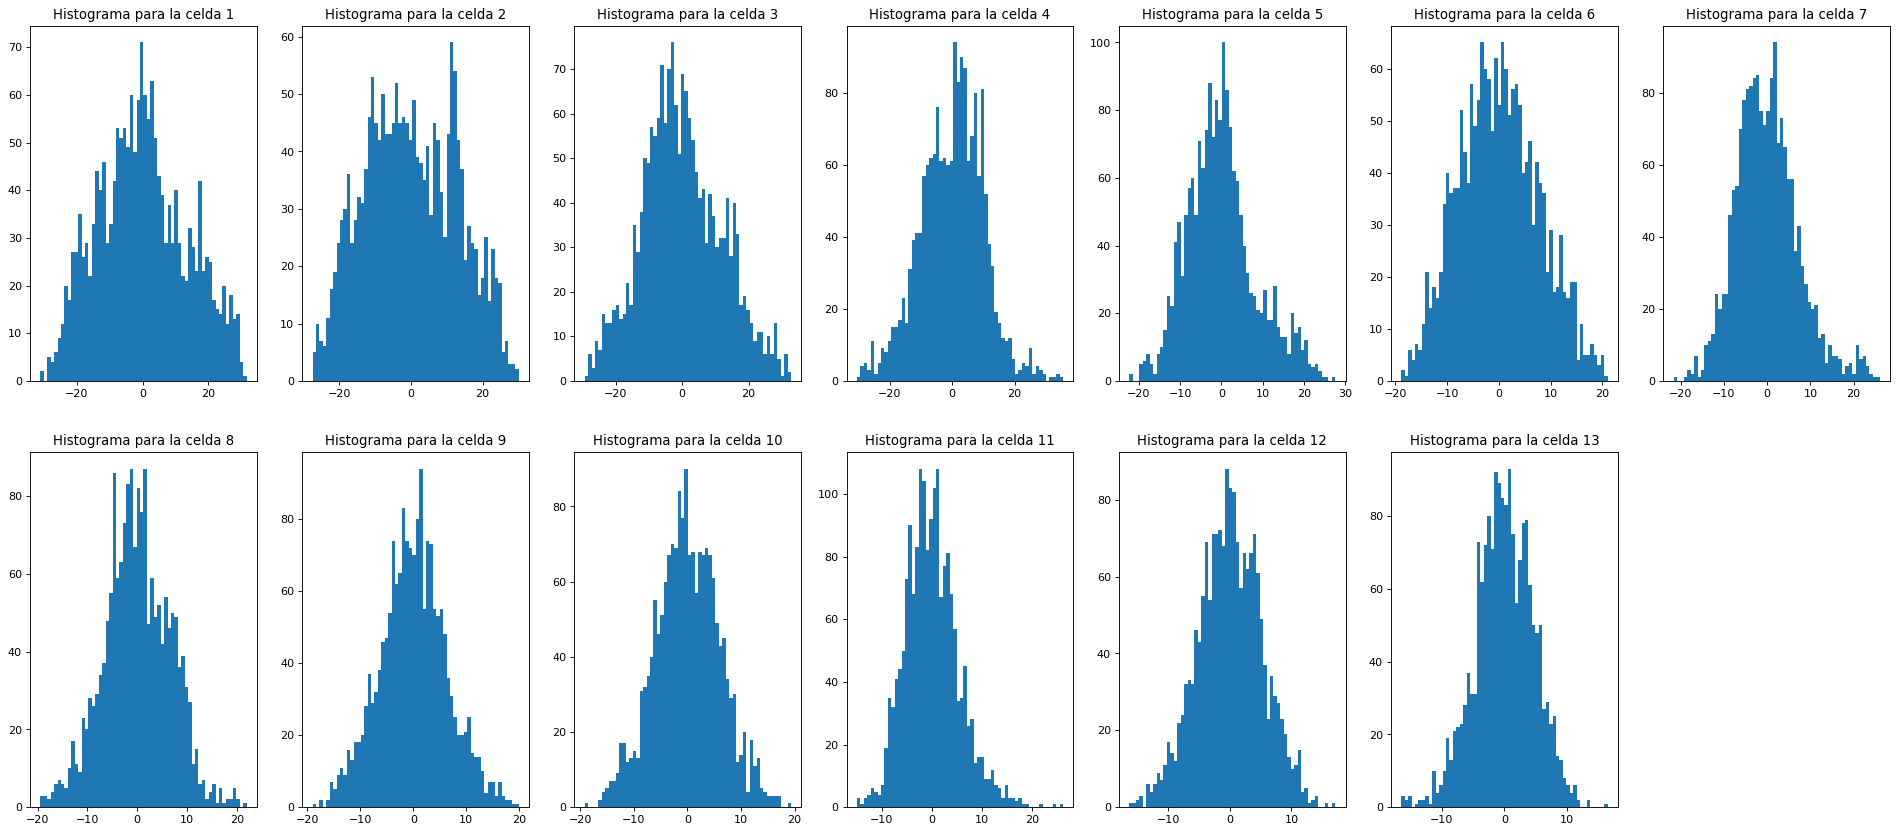

In [35]:
figure(num=None, figsize=(30, 20), dpi=80) #Ajustamos nuestra ventana de ploteo
M=newDataframe.drop(['target',], axis=1)
j=0 #Establesemos un contador para el ploteo.
for i in M.columns: #Recorremos las columnas y generamos un histograma por vcada una de ellas.
    j+=1
    plt.subplot(3,7,j)
    plt.hist(M[i], bins = 60)
    plt.title('Histograma para la celda '+i)
    #plt.xlabel('Celda',i)
    #plt.ylabel('Frecuencia')


plt.show()

In [36]:
X = newDataframe.drop(columns="target").values
y = newDataframe["target"].values
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [37]:
from sklearn.svm import SVC
from sklearn import svm
clf_final.fit(X_train,Y_train)
Y_pred=clf_final.predict(X_test)
print('\nMatriz de confusion:\n ')
print(confusion_matrix(Y_test,Y_pred))
df_temp = pd.DataFrame(
    {
        'y':Y_test,
        'yhat':Y_pred
        }
)

df_metrics = summary_metrics(df_temp)
print("")
print(df_metrics)



Matriz de confusion:
 
[[33  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 34  0  0  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  0  0 46  1  0  0  0]
 [ 0  0  0  0  0  0 35  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  1]
 [ 0  0  1  0  0  1  0  0 28  0]
 [ 0  0  0  0  0  1  0  1  0 38]]

   accuracy  recall  precision  fscore
0    0.9833  0.9833     0.9846  0.9838


### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [60]:
def mostar_resultados(digits,model,nx=5, ny=5,label = "correctos"):
    """
    Muestra los resultados de las prediciones de un modelo 
    de clasificacion en particular. Se toman aleatoriamente los valores
    de los resultados.
    
    - label == 'correcto': retorna los valores en que el modelo acierta.
    - label == 'incorrecto': retorna los valores en que el modelo no acierta.

    
    Observacion: El modelo que recibe como argumento debe NO encontrarse
    'entrenado'.
    
    
    :param digits: dataset 'digits'
    :param model: modelo de sklearn
    :param nx: numero de filas (subplots)
    :param ny: numero de columnas (subplots)
    :param label: datos correctos o incorrectos
    :return: graficos matplotlib
    """
    
    
    X = digits.drop(columns="target").values
    Y = digits["target"].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42) 
    model.fit(X_train, Y_train) # ajustando el modelo
    Y_pred = list(model.predict(X_test))

    
    # Mostrar los datos correctos
    if label=="correctos":
        mask = Y_pred == Y_test
        color = "green"
        
    # Mostrar los datos correctos
    elif label=="incorrectos":
        mask = Y_pred != Y_test
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
        
    X_aux = X_test[mask]
    y_aux_true = np.array(Y_test)[mask]
    y_aux_pred = np.array(Y_pred)[mask]

    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            data  = X_aux[index, :].reshape(8,8)
            label_pred = str(int(y_aux_pred[index]))
            label_true = str(int(y_aux_true[index]))
            ax[i][j].imshow(data, interpolation='nearest', cmap='gray_r')
            ax[i][j].text(0, 0, label_pred, horizontalalignment='center', verticalalignment='center', fontsize=10, color=color)
            ax[i][j].text(7, 0, label_true, horizontalalignment='center', verticalalignment='center', fontsize=10, color='blue')
            ax[i][j].get_xaxis().set_visible(False)
            ax[i][j].get_yaxis().set_visible(False)
    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

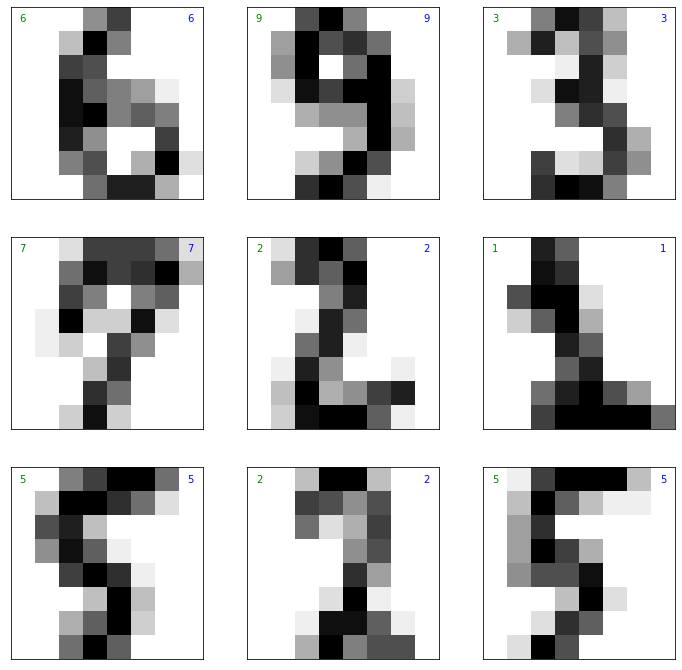

In [68]:
mostar_resultados(digits,SVC(kernel=grid.best_params_['kernel'], C=grid.best_params_['C'],decision_function_shape=grid.best_params_['decision_function_shape']),nx=3, ny=3,label = "correctos")

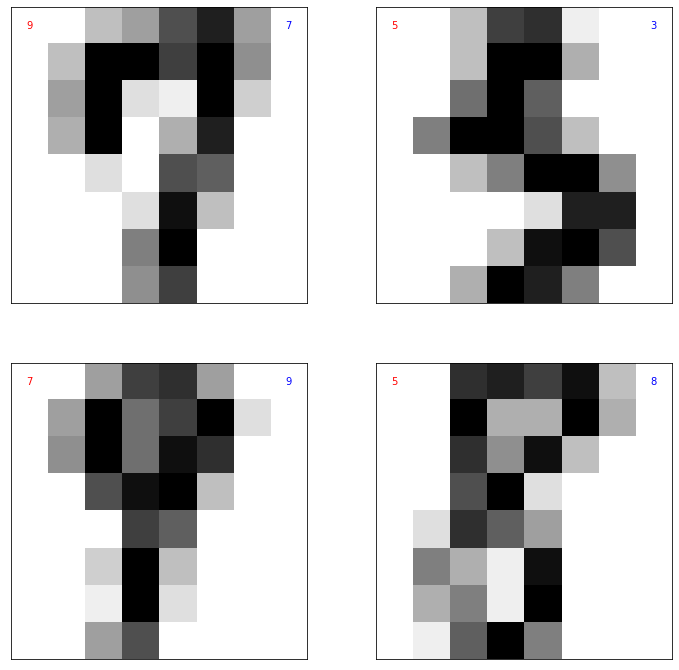

In [74]:
mostar_resultados(digits,SVC(kernel=grid.best_params_['kernel'], C=grid.best_params_['C'],decision_function_shape=grid.best_params_['decision_function_shape']),nx=2, ny=2,label = "incorrectos")

### Ejercicio 7
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.

Sin dudas me parece que la moralega de este trabajo radica en entender que el objetivo de todo modelo se basa en mantener un equilibrio entre la cantidad de informacion que nesesito versus la calidad de los resultados que obtengo. En este sentido uno podria pensar que si se trabajara con imagenes con mejor resolucion se obtendria un modelo mas presiso , sin embargo aqui vemos que sin mas que unos cuantos pixeles para cada imagen somo capaces de obtener resultados mas que satisfactorios con casi todos lo modelos que fueron aplicados.